In [96]:
import pandas as pd
import json
json_file_path = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/annotations/instances_val.json'

In [97]:
with open(json_file_path) as json_file:
    data = json.load(json_file)

In [145]:
data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [146]:
data['categories']

[{'supercategory': 'ignored', 'id': 0, 'name': 'ignored'},
 {'supercategory': 'person', 'id': 1, 'name': 'swimmer'},
 {'supercategory': 'boat', 'id': 2, 'name': 'boat'},
 {'supercategory': 'boat', 'id': 3, 'name': 'jetski'},
 {'supercategory': 'object', 'id': 4, 'name': 'life_saving_appliances'},
 {'supercategory': 'object', 'id': 5, 'name': 'buoy'}]

In [98]:
val_annot = pd.DataFrame.from_dict(data['annotations']) # annotations of the validation. Have to check the bbox to see if they follow darknet

In [99]:
val_annot

id  image_id                    bbox   area  category_id
0     14808      3464  [1698, 1619, 230, 164]  37720            1
1     14809      3465  [1692, 1553, 296, 196]  58016            1
2     14810      3466       [0, 654, 138, 38]   5244            2
3     14812      3466  [1724, 1491, 266, 132]  35112            1
4     14813      3467     [142, 668, 194, 40]   7760            2
...     ...       ...                     ...    ...          ...
9625   6066      1500    [1205, 958, 201, 94]  18894            2
9626   6067      1500     [1610, 523, 90, 76]   6840            1
9627   6069      1500  [2960, 1064, 107, 206]  22042            2
9628   6070      1500     [3227, 613, 40, 64]   2560            1
9629   2986       830      [682, 702, 17, 22]    374            1

[9630 rows x 5 columns]

## chekcing the bounding boxes

In [100]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches# Create figure and axes

In [164]:
# Pick one of the annotations to check the boundinb boxes
the_choosen_anot = val_annot.iloc[550]
the_choosen_anot

id                           21571
image_id                      4438
bbox           [3052, 731, 17, 12]
area                           204
category_id                      1
Name: 550, dtype: object

In [165]:
all_annots_of_image = val_annot[val_annot['image_id']==the_choosen_anot['image_id']]['bbox']
all_annots_of_image

539     [2552, 757, 135, 34]
540    [2387, 1004, 174, 78]
541     [3451, 880, 111, 60]
542      [2819, 687, 16, 13]
543      [2865, 714, 13, 10]
544      [2970, 695, 14, 12]
545      [3014, 773, 23, 17]
546      [2791, 671, 14, 12]
547      [3150, 777, 16, 13]
548      [3304, 728, 53, 35]
549      [3033, 688, 12, 12]
550      [3052, 731, 17, 12]
551      [3217, 720, 19, 18]
552      [3191, 799, 17, 13]
553      [2757, 723, 15, 13]
Name: bbox, dtype: object

In [166]:
the_choosen_anot['bbox']

[3052, 731, 17, 12]

In [167]:
df = pd.DataFrame(list(all_annots_of_image),columns=['x1', 'y1', 'w', 'h'])

In [168]:
df
#df.append(the_choosen_anot['bbox'],ignore_index=True)

x1    y1    w   h
0   2552   757  135  34
1   2387  1004  174  78
2   3451   880  111  60
3   2819   687   16  13
4   2865   714   13  10
5   2970   695   14  12
6   3014   773   23  17
7   2791   671   14  12
8   3150   777   16  13
9   3304   728   53  35
10  3033   688   12  12
11  3052   731   17  12
12  3217   720   19  18
13  3191   799   17  13
14  2757   723   15  13

In [169]:
imname = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/val/'+str(the_choosen_anot['image_id'])+'.jpg'
im = Image.open(imname)
imr = np.array(im, dtype=np.uint8)




In [170]:
imr.shape

(2160, 3840, 3)

In [171]:
df_scaled = df.iloc[:, 0:]
df_scaled[['x1', 'w']] = df_scaled[['x1', 'w']] #* imr.shape[1]
df_scaled[['y1', 'h']] = df_scaled[['y1', 'h']] #* imr.shape[0]

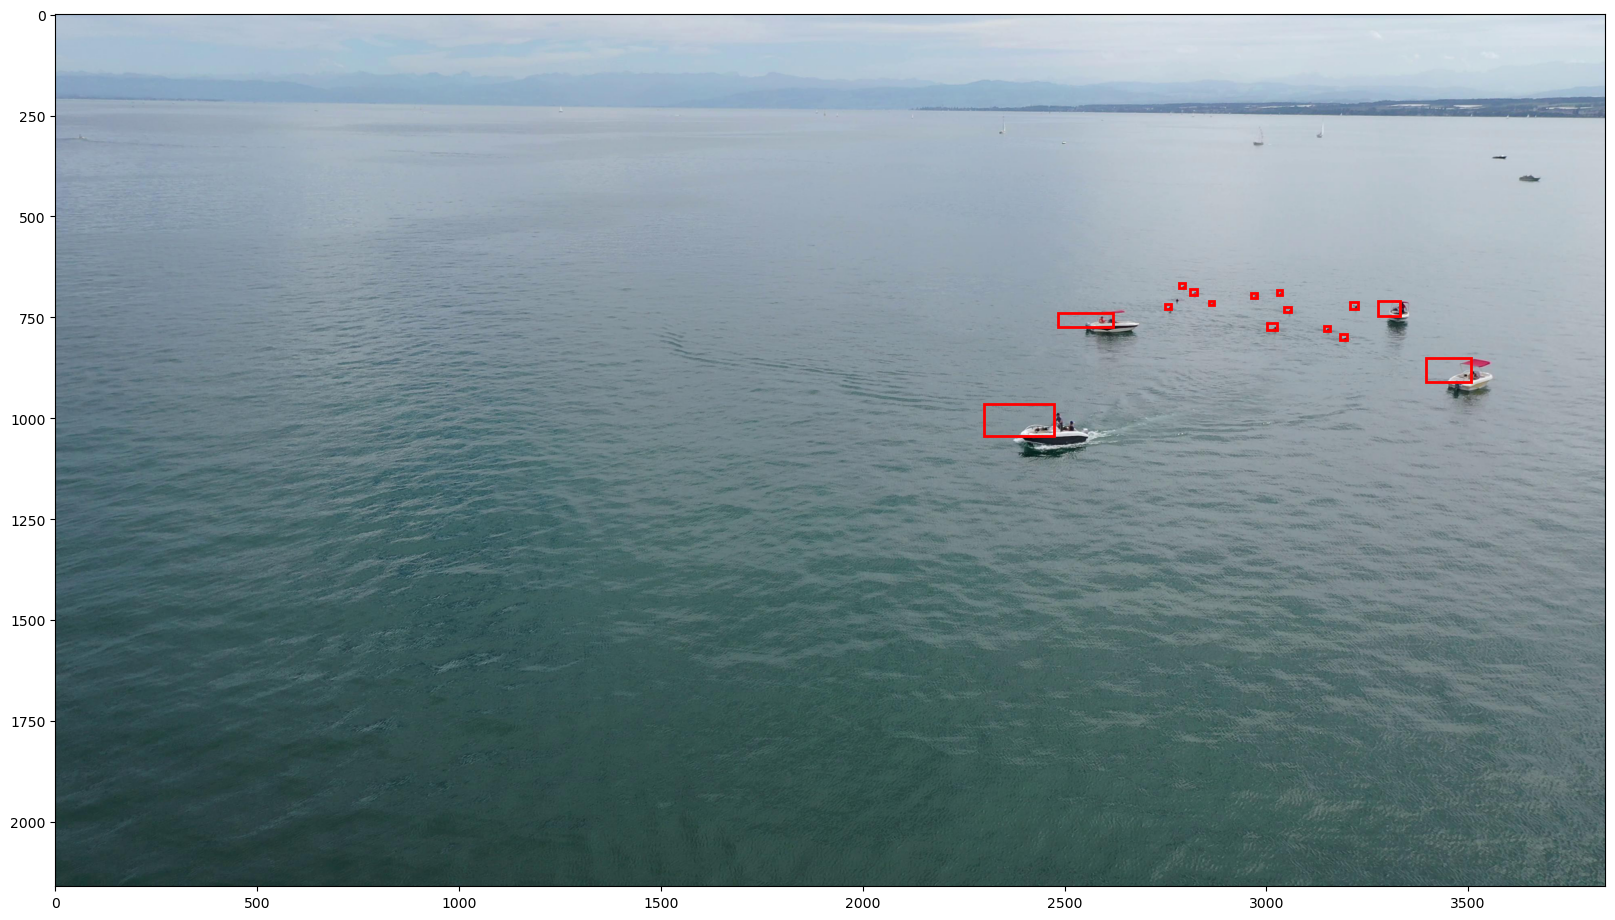

In [172]:

fig,ax = plt.subplots(1, figsize=(20,20))# Display the image
ax.imshow(imr)
for box in df_scaled.values:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0]-(box[2]/2),box[1]-(box[3]/2)),box[2],box[3],linewidth=2,edgecolor='r',facecolor='none')# Add the patch to the axes
    ax.add_patch(rect)
#plt.grid(alpha = 1)    
plt.show()

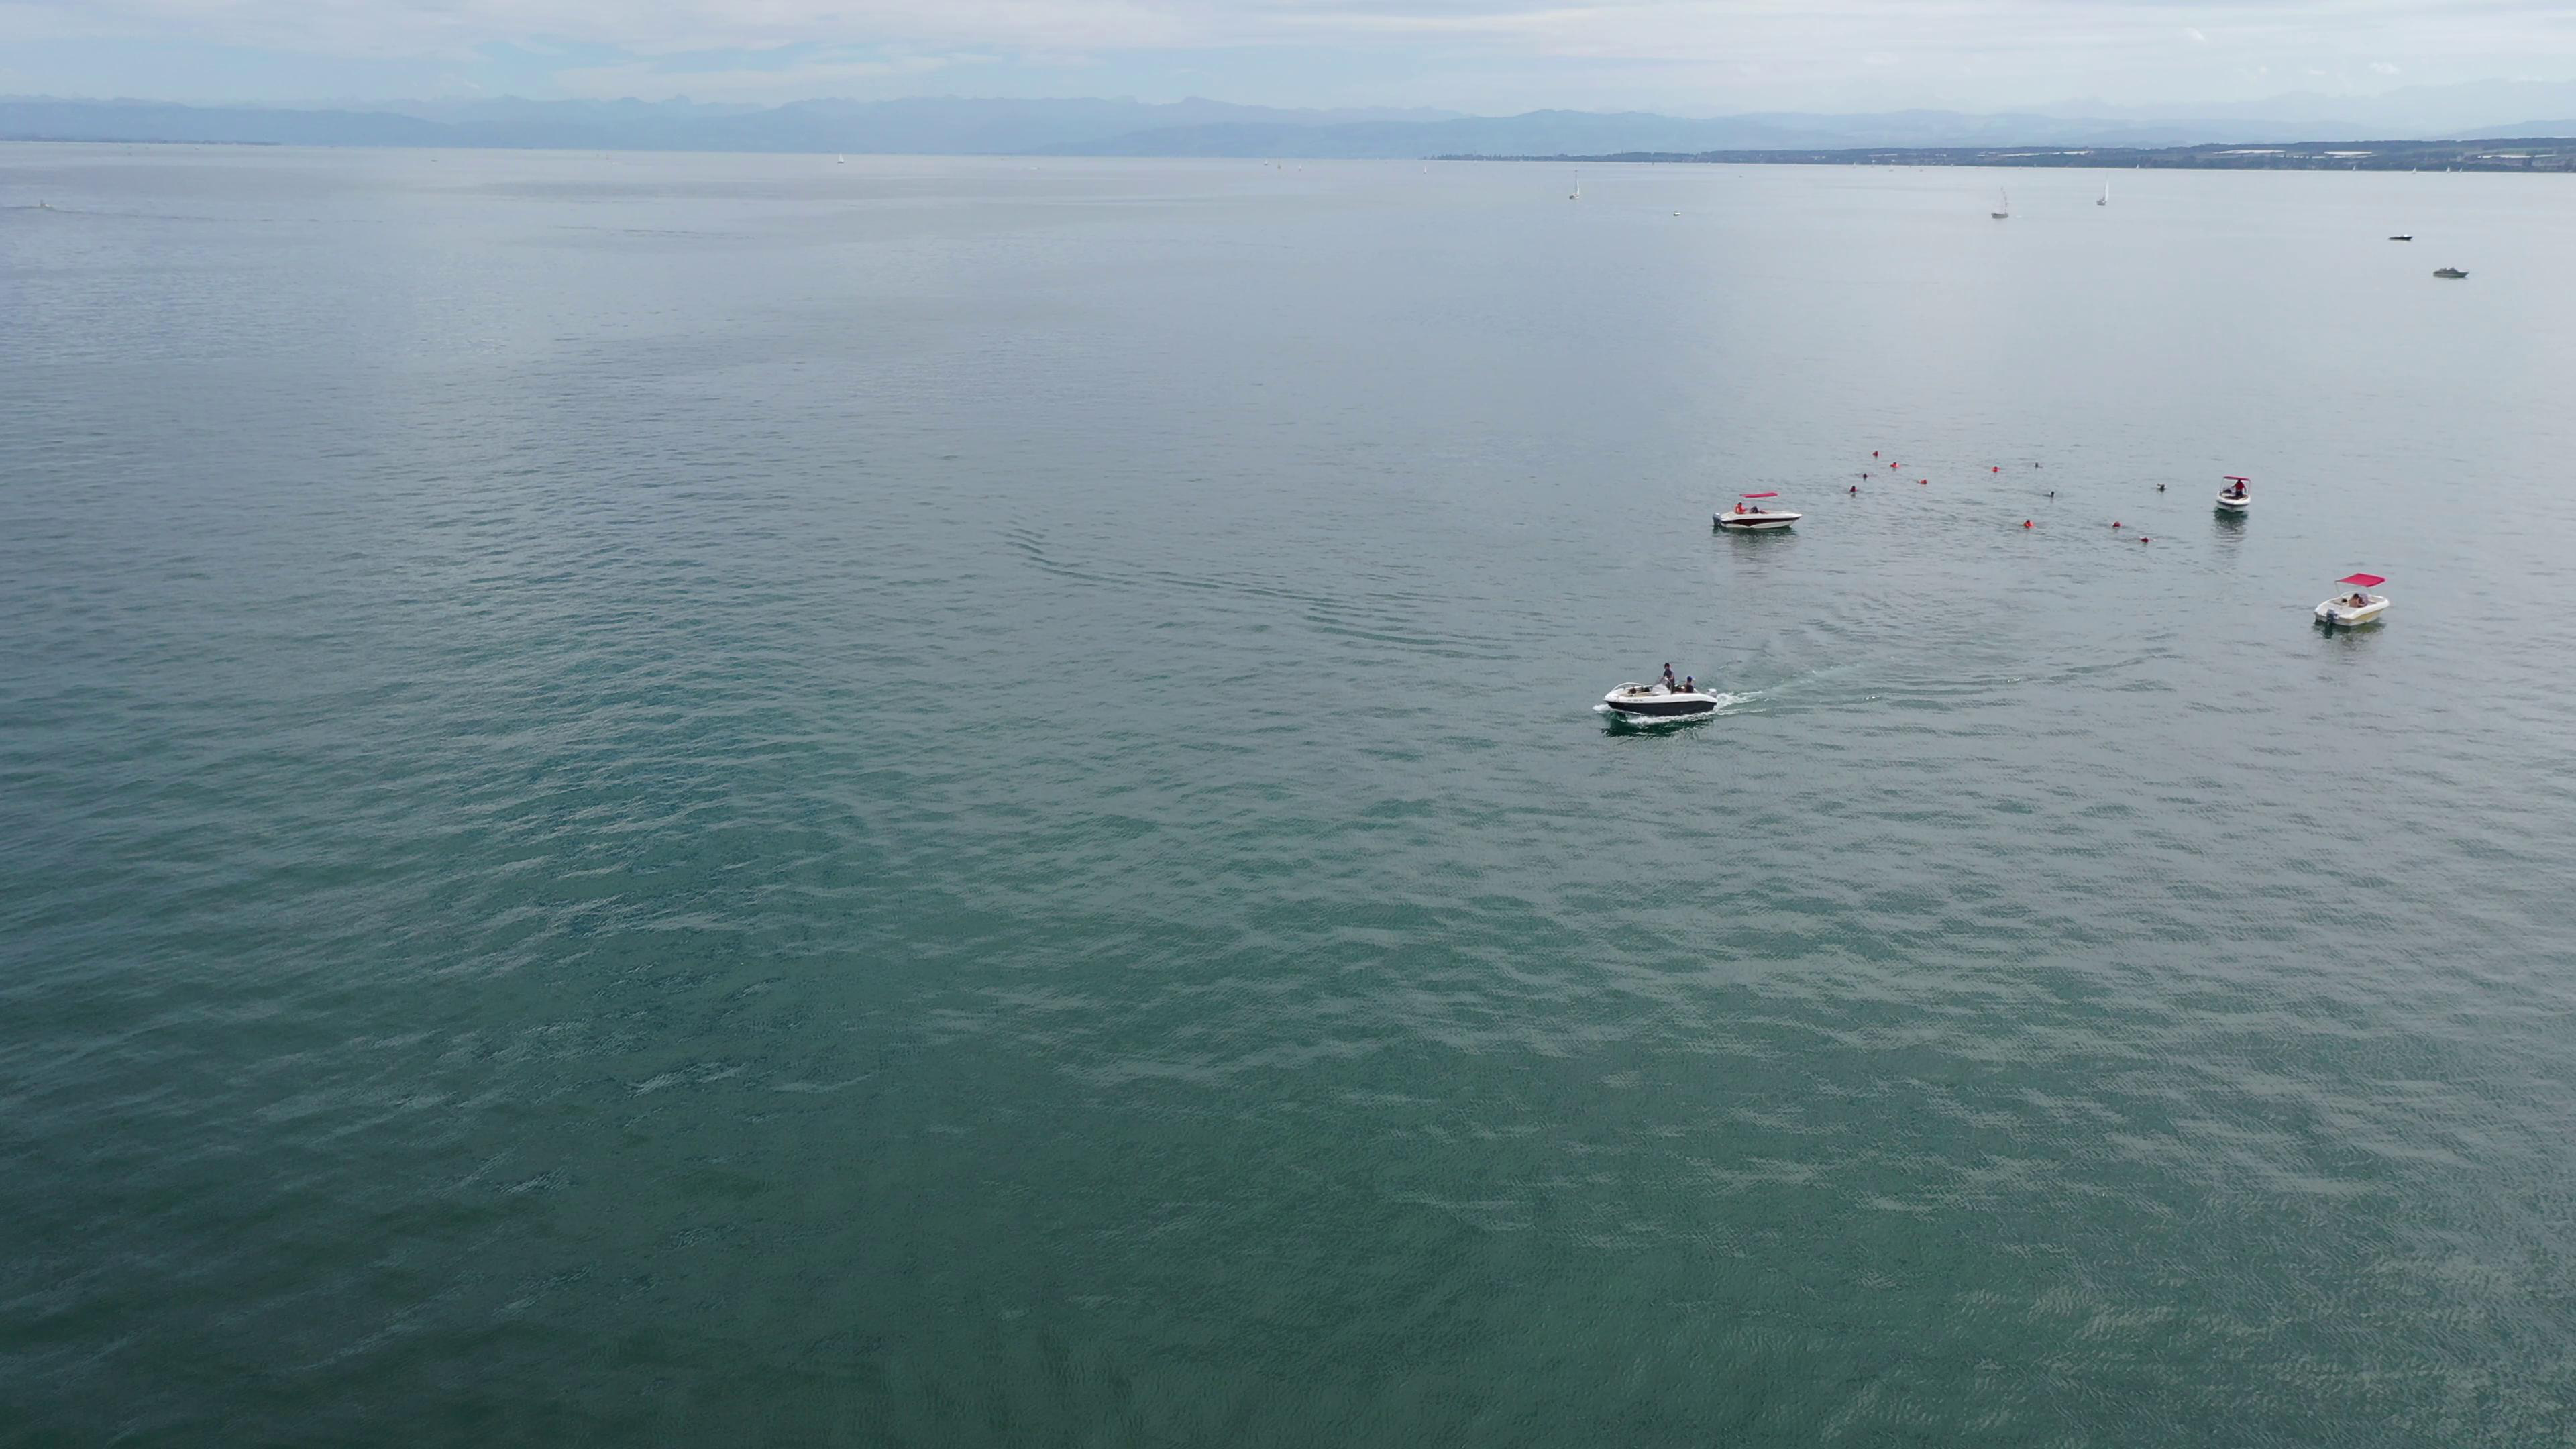

In [173]:
im

# Setting up the new pipeline


In [1]:
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import json

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches# Create figure and axes

In [11]:
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
from datetime import datetime


from pathlib import Path
from PIL import Image
import numpy as np
from shapely.geometry import Polygon, Point

from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

import tensorflow as tf

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

In [45]:
# Use the validation as the test dataset
json_train_file_path = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/annotations/instances_train.json'
json_test_file_path = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/annotations/instances_val.json'

In [46]:
with open(json_train_file_path) as json_file:
    train_data = json.load(json_file)
train_annot = pd.DataFrame.from_dict(train_data['annotations']) # annotations of the validation. Have to check the bbox to see if they follow darknet

In [47]:
with open(json_test_file_path) as json_file:
    test_data = json.load(json_file)
test_annot = pd.DataFrame.from_dict(test_data['annotations']) # annotations of the validation. Have to check the bbox to see if they follow darknet

In [48]:
train_data['categories']


[{'supercategory': 'ignored', 'id': 0, 'name': 'ignored'},
 {'supercategory': 'person', 'id': 1, 'name': 'swimmer'},
 {'supercategory': 'boat', 'id': 2, 'name': 'boat'},
 {'supercategory': 'boat', 'id': 3, 'name': 'jetski'},
 {'supercategory': 'object', 'id': 4, 'name': 'life_saving_appliances'},
 {'supercategory': 'object', 'id': 5, 'name': 'buoy'}]

In [49]:
train_annot

id  image_id                   bbox   area  category_id
0      14579      3388   [3619, 1409, 75, 38]   2850            2
1      14581      3389   [3524, 1408, 73, 37]   2701            2
2      14583      3390   [3399, 1406, 71, 36]   2556            2
3      14585      3391   [3267, 1152, 70, 35]   2450            2
4      14587      3392    [3053, 784, 65, 33]   2145            2
...      ...       ...                    ...    ...          ...
57755    498        60     [471, 238, 14, 10]    140            1
57756    499        60     [539, 270, 15, 12]    180            1
57757   6472      1608  [2249, 3427, 176, 99]  17424            2
57758   8281      1836   [1712, 1473, 95, 68]   6460            2
57759   8282      1836    [3285, 164, 66, 93]   6138            2

[57760 rows x 5 columns]

In [52]:
imname = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/train/2.jpg'
train_annot[train_annot['image_id']==int(imname.split('/')[-1].replace('.jpg',''))]['bbox']

53729    [315, 296, 42, 26]
53730    [405, 118, 35, 38]
53731    [926, 121, 44, 26]
53732    [354, 314, 12, 10]
53733    [506, 177, 16, 11]
53734     [523, 88, 18, 10]
53735    [556, 118, 20, 10]
53736    [602, 129, 10, 14]
53737     [686, 94, 18, 11]
53738     [893, 93, 18, 14]
53739    [837, 127, 21, 13]
53740    [582, 215, 24, 10]
53741    [500, 101, 13, 10]
Name: bbox, dtype: object

In [17]:
# For now considering only humans as important category
train_annot = train_annot[train_annot['category_id']==1]
test_annot = test_annot[test_annot['category_id']==1]

In [63]:
# Tiler


def tiler(imname,train_flag):
    slice_size = 250
    newpath = '/Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/{}/ts/'.format(train_flag)

    falsepath = '/Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/{}/false/'.format(train_flag)
    #creating a new directory called pythondirectory
    Path(newpath).mkdir(parents=True, exist_ok=True)
    Path(falsepath).mkdir(parents=True, exist_ok=True)
    im = Image.open(imname)
    imr = np.array(im, dtype=np.uint8)
    height = imr.shape[0]
    width = imr.shape[1]
    
    if train_flag == 'train':
        
        all_annots_of_image = train_annot[train_annot['image_id']==int(imname.split('/')[-1].replace('.jpg',''))]['bbox']
    elif train_flag == 'test':    
        all_annots_of_image = test_annot[test_annot['image_id']==int(imname.split('/')[-1].replace('.jpg',''))]['bbox']
        
    labels = pd.DataFrame(list(all_annots_of_image),columns=['x1', 'y1', 'w', 'h'])
    print(all_annots_of_image)
    
    #labname = imname.split('/')[-1].replace('.jpg', '.txt')
    #labels = pd.read_csv(root_path+'2categories/'+labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
    #labels = labels[labels['class']==0] # Only taking into consideration small objects
    
    # we need to rescale coordinates from 0-1 to real image height and width
    #labels[['x1', 'w']] = labels[['x1', 'w']] #* width
    #labels[['y1', 'h']] = labels[['y1', 'h']] #* height
    
    boxes = []
    #print(labels)
    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for row in labels.iterrows():
        x1 = row[1]['x1'] - row[1]['w']/2
        y1 = (height - row[1]['y1']) - row[1]['h']/2
        x2 = row[1]['x1'] + row[1]['w']/2
        y2 = (height - row[1]['y1']) + row[1]['h']/2

        boxes.append((int(1), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
    
    counter = 0
    #print('Image:', imname)
    # create tiles and find intersection with bounding boxes for each tile
    fig, axs = plt.subplots((height // slice_size)+int(bool(height%slice_size)),(width // slice_size)+int(bool(width%slice_size)))    
    for i in range((height // slice_size)+int(bool(height%slice_size))):
        for j in range((width // slice_size)+int(bool(width%slice_size))):
            
            if (i == (height // slice_size)) and (j != (width//slice_size)):
                sliced = imr[height - slice_size:height, j*slice_size:(j+1)*slice_size]
                x1 = width - slice_size
                y1 = height - (i*slice_size)
                x2 = width
                y2 = (height - (i+1)*slice_size) + 1
                
            elif (i != (height // slice_size)) and (j == (width//slice_size)):
                sliced = imr[i*slice_size:(i+1)*slice_size, width - slice_size:width]
                x1 = j*slice_size
                y1 = height - (height - slice_size)
                x2 = ((j+1)*slice_size) - 1
                y2 = 0
                
            elif (i == (height // slice_size)) and (j == (width//slice_size)):
                sliced = imr[height - slice_size:height, width - slice_size:width]
                x1 = width - slice_size
                y1 = height - (height - slice_size)
                x2 = width
                y2 = 0
            
            elif (i != (height // slice_size)) and (j != (width//slice_size)) :
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                x1 = j*slice_size
                y1 = height - (i*slice_size)
                x2 = ((j+1)*slice_size) - 1
                y2 = (height - (i+1)*slice_size) + 1
            
           # print(sliced.shape)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            imsaved = False
            slice_labels = []
            
            
            
            for box in boxes:
                if pol.intersects(box[1]):
                    inter = pol.intersection(box[1])        
                    
                    if not imsaved:
                      
                        sliced_im = Image.fromarray(sliced)
                        filename = imname.split('/')[-1]
                        ##filename = imname
                        slice_path = newpath + filename.replace('.jpg', f'_{i}_{j}.jpg')
                        
                        slice_labels_path = newpath + filename.replace('.jpg', f'_{i}_{j}.txt')
                        
                       # print(slice_path)
                        #print('hi')
                        sliced_im.save(slice_path)
                        imsaved = True                    
                    
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get central point for the new bounding box 
                    centre = new_box.centroid
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    # get bounding box width and height normalized to slice size
                    new_width = (max(x) - min(x)) / slice_size
                    new_height = (max(y) - min(y)) / slice_size
                    
                    # we have to normalize central x and invert y for yolo format
                    new_x = (centre.coords.xy[0][0] - x1) / slice_size
                    new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                    
                    counter += 1

                    slice_labels.append([box[0], new_x, new_y, new_width, new_height])
                    
            if len(slice_labels) > 0:
                slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                #print(slice_df)
                slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
            
            # if there are no bounding boxes intersect current tile, save this tile to a separate folder 
            if not imsaved:
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                sliced_im = Image.fromarray(sliced)
                filename = imname.split('/')[-1]
                #filename = imname
                slice_path = falsepath + filename.replace('.jpg', f'_{i}_{j}.jpg')                

                sliced_im.save(slice_path)
                #print('Slice without boxes saved')
                imsaved = True
    plt.close()

In [64]:
# tiler(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/train/2.jpg','train')
# imname = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/train/2.jpg'

In [65]:
# imname = r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/train/2.jpg'
# train_annot[train_annot['image_id']==imname.split('/')[-1].replace('.jpg','')]['bbox']

In [66]:
%%time
#dont run

Parallel(n_jobs=num_cores)(delayed(tiler)(imname,'train') for imname in glob.glob(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/train/*.jpg'))

10950     [1918, 864, 96, 67]
10951    [1974, 1326, 46, 69]
10952       [951, 19, 34, 91]
10953      [692, 71, 31, 108]
10954      [637, 99, 35, 117]
10955    [2083, 1160, 16, 28]
10956    [2169, 1216, 45, 21]
10957    [2250, 1246, 32, 17]
10958    [2170, 1260, 29, 23]
10959    [2000, 1252, 19, 22]
10960    [1897, 1229, 16, 19]
Name: bbox, dtype: object
49352    [1838, 721, 309, 151]
49353       [861, 21, 186, 77]
Name: bbox, dtype: object
1551    [313, 819, 116, 32]
1552    [1024, 580, 83, 28]
1553    [1263, 695, 49, 44]
1554    [1438, 468, 73, 25]
1555     [991, 723, 16, 16]
1556     [956, 623, 15, 13]
Name: bbox, dtype: object
4252     [1823, 1270, 49, 57]
4253     [1966, 1269, 77, 84]
4254    [1377, 854, 179, 112]
4255    [844, 1828, 346, 279]
4256     [1652, 641, 179, 65]
4257     [2138, 1202, 83, 74]
4258      [1972, 973, 47, 44]
4259    [1677, 407, 115, 108]
Name: bbox, dtype: object
26480     [1897, 282, 47, 68]
26481    [1923, 1478, 63, 41]
26482    [3447, 2129, 65, 31]
Name: 

32803     [2151, 1582, 53, 40]
32804     [2302, 1606, 28, 42]
32805    [1871, 1125, 255, 92]
32806    [1835, 1181, 198, 47]
Name: bbox, dtype: object
48454    [1177, 519, 37, 33]
48455     [887, 347, 20, 26]
48456    [1254, 454, 20, 25]
48457    [1247, 495, 62, 43]
48458     [820, 309, 31, 27]
48459    [1141, 371, 49, 32]
48460     [655, 701, 25, 25]
48461     [793, 805, 33, 43]
48462    [932, 900, 109, 37]
Name: bbox, dtype: object
10591    [2822, 997, 178, 93]
10592    [1919, 1420, 23, 29]
10593    [2087, 1456, 62, 20]
10594    [1695, 1508, 48, 71]
10595    [1846, 1414, 32, 21]
10596    [2074, 1507, 60, 24]
10597    [1995, 1501, 25, 16]
10598    [2117, 1396, 19, 24]
10599       [2528, 8, 38, 92]
10600     [2450, 31, 39, 102]
10601       [2826, 1, 37, 49]
Name: bbox, dtype: object
1533    [348, 804, 116, 32]
1534    [1074, 566, 83, 28]
1535    [1499, 457, 73, 25]
1536    [1013, 607, 15, 13]
1537    [1305, 688, 41, 45]
1538    [1037, 709, 16, 15]
Name: bbox, dtype: object
53645    [673

48463    [1173, 528, 35, 34]
48464     [887, 357, 17, 29]
48465    [1246, 461, 20, 26]
48466    [1241, 501, 64, 41]
48467     [821, 319, 37, 30]
48468    [1135, 384, 42, 29]
48469     [658, 701, 27, 27]
48470     [793, 806, 31, 41]
48471     [939, 901, 99, 38]
Name: bbox, dtype: object
4044     [1786, 1033, 59, 69]
4045     [2016, 1124, 60, 85]
4046    [1344, 539, 207, 128]
4047    [776, 1664, 402, 265]
4048     [1649, 288, 198, 76]
4049     [2219, 1007, 81, 93]
4050      [1907, 591, 49, 45]
4051     [1702, 11, 124, 121]
Name: bbox, dtype: object
26395    [1732, 1992, 231, 168]
26396     [1599, 2020, 87, 108]
26397     [2260, 1680, 137, 68]
26398       [1776, 381, 61, 45]
Name: bbox, dtype: object
29970    [3243, 593, 210, 162]
29971     [3004, 573, 178, 95]
29972        [46, 626, 68, 86]
29973     [1697, 1427, 85, 42]
29974      [2578, 994, 23, 24]
29975       [748, 942, 26, 34]
29976       [690, 909, 24, 26]
29977       [514, 983, 20, 29]
29978     [1990, 1493, 49, 37]
29979     [281

42134       [783, 196, 18, 19]
42135       [957, 360, 21, 20]
42136       [265, 418, 24, 21]
42137       [228, 449, 23, 22]
42138      [1044, 490, 58, 28]
42139       [356, 465, 26, 24]
42140       [497, 404, 21, 23]
42141       [667, 661, 45, 55]
42142       [896, 428, 18, 21]
42143       [273, 904, 65, 72]
42144    [1712, 648, 198, 317]
42145       [573, 122, 12, 16]
42146       [944, 397, 27, 29]
Name: bbox, dtype: object
34971    [1857, 844, 52, 58]
34972    [1740, 887, 38, 45]
34973    [1193, 205, 39, 68]
Name: bbox, dtype: object
10580    [2850, 1012, 175, 95]
10581     [1890, 1427, 31, 21]
10582     [2053, 1464, 61, 20]
10583     [1656, 1510, 48, 71]
10584     [1817, 1415, 39, 20]
10585     [2036, 1509, 59, 28]
10586     [1955, 1501, 25, 19]
10587     [2090, 1402, 18, 22]
10588       [2617, 11, 48, 88]
10589      [2539, 30, 41, 102]
10590        [2924, 0, 39, 49]
Name: bbox, dtype: object
55471    [0, 5275, 406, 181]
Name: bbox, dtype: object
2986    [1543, 1205, 35, 76]
2987   

1635     [90, 918, 122, 35]
1636     [741, 667, 87, 30]
1637     [985, 761, 90, 34]
1638    [1110, 556, 73, 23]
1639     [739, 809, 18, 17]
1640     [622, 730, 21, 15]
Name: bbox, dtype: object
26453    [2014, 2034, 89, 52]
26454     [1869, 754, 77, 51]
Name: bbox, dtype: object
32807     [2621, 1342, 38, 36]
32808     [2195, 1452, 45, 33]
32809     [2110, 1515, 71, 29]
32810     [1786, 1655, 62, 30]
32811     [1793, 1531, 30, 37]
32812     [1854, 1590, 52, 36]
32813     [2281, 1526, 39, 35]
32814     [2322, 1605, 52, 40]
32815     [2153, 1544, 52, 37]
32816     [2300, 1561, 30, 41]
32817    [1870, 1090, 260, 89]
32818    [1835, 1145, 201, 48]
Name: bbox, dtype: object
41943     [966, 245, 18, 20]
41944     [792, 171, 25, 26]
41945     [1103, 50, 42, 58]
41946    [1261, 387, 22, 23]
41947    [1232, 428, 24, 27]
41948     [569, 452, 25, 25]
41949     [529, 471, 22, 23]
41950    [1114, 455, 20, 19]
41951     [672, 490, 35, 27]
41952     [792, 428, 39, 34]
41953    [1021, 653, 29, 28]
419

15933     [1006, 374, 18, 17]
15934     [1243, 441, 19, 17]
Name: bbox, dtype: object
26651       [1841, 725, 39, 54]
26652      [1947, 1482, 42, 29]
26653    [3262, 1695, 291, 167]
26654      [1675, 1926, 33, 51]
26655     [2026, 1593, 89, 111]
26656      [2642, 1893, 53, 35]
26657      [2976, 1836, 29, 30]
Name: bbox, dtype: object
15403     [2536, 948, 46, 61]
15404    [1269, 1432, 38, 79]
15405    [1784, 1379, 23, 22]
15406    [1743, 1268, 20, 20]
15407    [1548, 1320, 16, 19]
15408    [1758, 1514, 16, 32]
15409    [1632, 1546, 24, 25]
15410    [1473, 1586, 27, 22]
15411    [2170, 125, 234, 89]
15412    [1417, 1589, 30, 21]
15413     [902, 1587, 31, 28]
Name: bbox, dtype: object
57096    [4381, 2637, 201, 338]
57097      [4771, 2467, 23, 27]
57098      [5292, 2236, 59, 41]
57099      [5156, 2132, 36, 27]
57100      [4925, 1852, 33, 42]
Name: bbox, dtype: object
49348    [1833, 888, 277, 125]
49349      [931, 298, 183, 64]
Name: bbox, dtype: object
10972     [1912, 876, 94, 68]
1097

35637    [1734, 1160, 84, 45]
35638     [1676, 934, 57, 65]
Name: bbox, dtype: object
3023    [1527, 1186, 40, 87]
3024    [1514, 1256, 85, 26]
3025    [1918, 1316, 29, 20]
3026    [1639, 1307, 14, 19]
Name: bbox, dtype: object
35013    [1893, 647, 88, 34]
35014    [1804, 681, 27, 24]
35015    [1260, 180, 33, 52]
Name: bbox, dtype: object
57432    [783, 119, 26, 30]
Name: bbox, dtype: object
20372    [1729, 1611, 92, 119]
20373    [3731, 1906, 88, 105]
20374     [2239, 1166, 29, 27]
20375     [2484, 1076, 22, 21]
Name: bbox, dtype: object
56046    [2724, 1245, 67, 78]
56047    [2622, 1655, 62, 79]
56048    [2331, 1559, 86, 42]
56049    [2262, 1761, 73, 72]
Name: bbox, dtype: object
44330    [1181, 265, 32, 51]
44331     [511, 263, 46, 73]
44332     [329, 387, 36, 70]
44333     [721, 425, 43, 52]
44334     [938, 442, 28, 35]
44335    [1544, 494, 35, 39]
44336    [1124, 555, 26, 41]
44337    [1103, 583, 29, 39]
44338    [1376, 777, 34, 26]
44339    [1550, 691, 36, 47]
Name: bbox, dtype: 

54683    [320, 528, 19, 50]
Name: bbox, dtype: object
56893    [0, 2824, 140, 407]
Name: bbox, dtype: object
11104    [1689, 946, 146, 76]
11105    [1835, 1337, 45, 69]
11106       [897, 25, 38, 97]
11107      [636, 85, 35, 109]
11108     [563, 115, 40, 123]
11109    [1975, 1168, 22, 27]
11110    [2073, 1225, 35, 25]
11111    [2146, 1257, 20, 17]
11112    [2067, 1281, 31, 21]
11113    [1876, 1268, 22, 23]
11114    [1799, 1229, 19, 18]
Name: bbox, dtype: object
22861    [2400, 309, 154, 83]
22862     [681, 1653, 60, 38]
22863     [1268, 957, 31, 35]
22864     [1794, 732, 42, 33]
22865     [624, 1308, 71, 32]
22866     [556, 1258, 79, 38]
22867     [1316, 810, 37, 30]
22868     [1444, 686, 45, 29]
22869     [859, 1134, 28, 20]
22870    [1597, 210, 123, 39]
22871      [2409, 97, 50, 23]
22872     [1489, 679, 29, 14]
22873     [832, 1144, 35, 20]
Name: bbox, dtype: object
56646    [3966, 990, 76, 76]
Name: bbox, dtype: object
26665       [1841, 706, 38, 53]
26666      [1947, 1429, 49, 34]


30048     [3335, 719, 205, 91]
30049       [473, 438, 57, 78]
30050     [1676, 1352, 53, 55]
30051     [2741, 1093, 22, 25]
30052       [985, 815, 22, 29]
30053       [956, 787, 18, 23]
30054       [775, 831, 16, 25]
30055     [1970, 1488, 39, 41]
30056     [2898, 1371, 43, 32]
30057       [552, 934, 31, 31]
30058     [1986, 1428, 34, 36]
30059     [2766, 1278, 26, 31]
30060    [3611, 754, 208, 193]
Name: bbox, dtype: object
15768       [1934, 501, 34, 46]
15769       [960, 1158, 62, 52]
15770       [1369, 834, 18, 17]
15771       [1328, 771, 18, 17]
15772       [1167, 780, 26, 20]
15773       [1391, 880, 16, 16]
15774       [1238, 928, 20, 20]
15775       [1120, 915, 28, 25]
15776       [1155, 941, 22, 17]
15777    [1175, 1264, 211, 122]
15778        [679, 996, 22, 25]
15779       [965, 1109, 18, 15]
Name: bbox, dtype: object
3004    [1491, 1197, 35, 79]
3005    [1436, 1259, 83, 27]
3006    [1793, 1321, 33, 22]
Name: bbox, dtype: object
35609    [2193, 1408, 37, 52]
35610    [1994, 14

36233     [973, 451, 16, 18]
36234     [739, 491, 16, 18]
36235     [747, 547, 18, 19]
36236    [1804, 165, 14, 25]
Name: bbox, dtype: object
5560    [2177, 1017, 187, 83]
5561     [1734, 1123, 93, 34]
5562      [1622, 992, 32, 26]
5563      [1582, 914, 50, 29]
5564     [2120, 575, 150, 95]
5565     [1057, 862, 94, 105]
5566     [982, 864, 112, 126]
Name: bbox, dtype: object
41371       [818, 260, 11, 13]
41372        [465, 94, 40, 54]
41373       [249, 530, 24, 30]
41374       [781, 356, 24, 20]
41375       [783, 232, 16, 17]
41376       [593, 379, 10, 11]
41377       [628, 395, 18, 26]
41378       [733, 693, 21, 23]
41379    [1479, 395, 217, 150]
Name: bbox, dtype: object
5738     [1754, 781, 259, 116]
5739     [2247, 488, 152, 262]
5740    [2285, 1365, 276, 143]
5741     [1824, 1407, 107, 60]
5742      [1686, 1239, 79, 59]
5743       [1593, 955, 67, 64]
5744      [1983, 1107, 66, 88]
5745      [1974, 1350, 56, 74]
5746       [1756, 905, 74, 54]
Name: bbox, dtype: object
20811       

7446      [825, 996, 252, 180]
7447    [1915, 1175, 155, 215]
7448       [1687, 864, 38, 39]
7449       [1699, 696, 41, 37]
7450      [1520, 1316, 83, 53]
7451       [2144, 982, 75, 33]
7452     [3513, 1859, 131, 88]
Name: bbox, dtype: object
17263     [2566, 913, 100, 75]
17264      [2262, 535, 33, 43]
17265    [2049, 1492, 134, 66]
17266     [2206, 1157, 27, 21]
17267        [1881, 0, 91, 94]
17268      [2033, 986, 20, 21]
17269     [1955, 1011, 20, 18]
17270     [1948, 1065, 24, 17]
17271     [1854, 1046, 21, 20]
17272     [1739, 1042, 31, 24]
17273     [1936, 1111, 42, 28]
17274     [1817, 1113, 33, 29]
17275     [1724, 1081, 45, 27]
17276       [2376, 32, 16, 19]
Name: bbox, dtype: object
57620    [476, 3504, 78, 74]
Name: bbox, dtype: object
17910    [2269, 1058, 169, 77]
17911      [2403, 679, 38, 44]
17912      [945, 1122, 40, 52]
17913      [2783, 17, 72, 136]
17914      [1677, 895, 35, 17]
17915      [1505, 957, 26, 15]
17916      [1407, 940, 22, 14]
17917     [1382, 1053, 21

32639     [2694, 1211, 43, 35]
32640     [2330, 1342, 39, 37]
32641    [2181, 1383, 100, 48]
32642     [2243, 1443, 59, 36]
32643     [1945, 1581, 87, 31]
32644     [1850, 1425, 32, 32]
32645     [1968, 1508, 50, 59]
32646     [2417, 1412, 24, 35]
32647     [2410, 1536, 60, 42]
32648     [2426, 1489, 35, 37]
32649     [1975, 908, 267, 94]
32650     [1934, 960, 209, 54]
Name: bbox, dtype: object
34463     [1929, 374, 66, 59]
34464    [2142, 1179, 48, 55]
34465    [1987, 1238, 40, 45]
Name: bbox, dtype: object
10646    [2712, 951, 172, 69]
10647    [2085, 1404, 22, 28]
10648    [2263, 1426, 58, 16]
10649    [1929, 1495, 48, 74]
10650    [2006, 1397, 29, 17]
10651    [2281, 1470, 55, 26]
10652    [2200, 1472, 23, 16]
10653    [2259, 1365, 18, 20]
10654      [2104, 33, 33, 93]
10655     [2041, 55, 35, 102]
10656       [2378, 2, 33, 71]
Name: bbox, dtype: object
23206    [2562, 1408, 51, 38]
23207    [1037, 1682, 32, 58]
23208    [1047, 1619, 49, 33]
23209    [2037, 1344, 32, 22]
23210    [

17952      [1299, 909, 19, 15]
17953     [1260, 1026, 20, 16]
17954      [1234, 963, 14, 12]
17955      [1275, 890, 16, 15]
17956      [1205, 900, 18, 14]
17957      [1225, 911, 14, 11]
Name: bbox, dtype: object
56113    [714, 346, 209, 71]
Name: bbox, dtype: object
14290       [1765, 736, 44, 59]
14291    [2013, 1470, 235, 168]
14292       [647, 1453, 33, 18]
14293      [1409, 1062, 25, 16]
14294      [1120, 1113, 22, 19]
14295      [1166, 1350, 32, 31]
14296      [1223, 1442, 71, 31]
14297      [1617, 1435, 28, 30]
14298       [756, 295, 255, 73]
14299      [1206, 1070, 22, 22]
14300      [1029, 1176, 19, 26]
14301        [396, 349, 65, 27]
Name: bbox, dtype: object
25882    [2803, 1412, 157, 173]
25883    [2890, 1327, 185, 256]
25884       [2567, 113, 33, 32]
25885      [1268, 1106, 89, 56]
25886       [1970, 800, 29, 26]
25887      [1927, 1127, 89, 48]
Name: bbox, dtype: object
14800    [2744, 1070, 41, 55]
14801    [2308, 300, 208, 71]
14802    [1258, 1580, 43, 18]
14803     [2122

AttributeError: 'Point' object has no attribute 'exterior'

In [67]:
%%time
#dont run

Parallel(n_jobs=num_cores)(delayed(tiler)(imname,'test') for imname in glob.glob(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/images/val/*.jpg'))

CPU times: user 38.2 s, sys: 11.9 s, total: 50.1 s
Wall time: 10min 59s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# Model training

In [68]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [69]:
result_root = r'/Users/krish/ljmu/3.results/{}/'.format(nb_name)
Path(result_root).mkdir(parents=True, exist_ok=True)

In [70]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/train/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/train/false/*.jpg')
df_false.humans = 0

tiled_train = df_true.append(df_false)

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_7322/2540842966.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_train = df_true.append(df_false)


In [71]:
tiled_train['humans'] = tiled_train.humans.apply(lambda x: str(x))

In [72]:
train_df, valid_df = train_test_split(tiled_train, 
                                   test_size = 0.15, 
                                   random_state = 1998,
                                   stratify = tiled_train['humans']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 713807 validation 125966


In [73]:
tiled_train

file_name humans
0       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      1
1       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      1
2       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      1
3       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      1
4       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      1
...                                                   ...    ...
803555  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      0
803556  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      0
803557  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      0
803558  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      0
803559  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...      0

[839773 rows x 2 columns]

In [74]:
# Rotation_range - random rotation within the angle mentioned
# Random_shifts - shifts 20% at max. to the horizontal and vertical(reduce to 10% as already diverse data)
# Random_flip - random flips 
# fill_mode - fill the blank pixels, when augmenting with the nearest color
datagen = ImageDataGenerator(rotation_range = 360,
                             width_shift_range=0.1, height_shift_range=0.1,
                             #horizontal_flip=True, vertical_flip=True, # Isnt much useful for us
                             brightness_range=[0.5,1.5],
                             rescale=1./255.,fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'file_name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=24)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'file_name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=24)

Found 713807 validated image filenames belonging to 2 classes.
Found 125966 validated image filenames belonging to 2 classes.


In [75]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer
# (224,224,3) is the default shape for imagent and that actually cant bechanged
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))



model.add(Dense(1, activation="sigmoid" , name="classification"))

2022-12-02 12:46:39.347656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 12:46:39.352273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [76]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.004,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1024)              5

In [77]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.5)

In [78]:
class_weight = {0:train_df['humans'].value_counts()[0]/train_df.shape[0],1:train_df['humans'].value_counts()[1]/train_df.shape[0],}

In [79]:
history = model.fit(train_generator, validation_data = valid_generator, epochs = 10, class_weight=class_weight,callbacks=[es])

Epoch 1/10


2022-12-02 12:46:42.741250: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 12:46:44.949991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  286/29742 [..............................] - ETA: 2:33:17 - loss: 0.0268 - accuracy: 0.94938850    [265, 350, 19, 35]
8851    [608, 112, 24, 28]
8852    [347, 192, 27, 30]
8853    [415, 303, 34, 22]
8854    [293, 239, 14, 13]
8855    [272, 222, 10, 17]
Name: bbox, dtype: object
8898    [421, 491, 54, 122]
Name: bbox, dtype: object
9159    [652, 55, 27, 27]
9160     [479, 7, 25, 33]
Name: bbox, dtype: object
5232    [2351, 878, 183, 120]
5233    [2246, 1096, 99, 113]
5234     [2706, 1669, 35, 25]
5235     [2827, 1462, 57, 52]
5236     [2813, 1500, 39, 27]
5237      [2523, 943, 29, 28]
5238      [2364, 968, 41, 28]
Name: bbox, dtype: object
1573      [2022, 702, 91, 170]
1574       [828, 838, 169, 83]
1575    [1171, 1569, 149, 129]
1576       [2019, 668, 54, 37]
1577       [2083, 685, 21, 35]
Name: bbox, dtype: object
6744     [849, 704, 31, 41]
6745     [636, 577, 40, 37]
6746     [795, 561, 38, 45]
6747    [825, 464, 101, 42]
6748     [465, 458, 41, 33]
6749    [1096, 978, 99, 77]
67

5005      [2310, 1377, 29, 22]
5006    [1764, 2055, 198, 105]
Name: bbox, dtype: object
3464     [1344, 891, 21, 52]
3465    [1257, 1103, 15, 19]
3466    [1082, 1033, 84, 24]
3467    [1009, 1202, 60, 24]
3468     [2194, 995, 12, 18]
Name: bbox, dtype: object
1772    [1952, 1705, 401, 156]
1773     [1916, 972, 192, 200]
1774     [2645, 670, 242, 110]
1775       [2610, 523, 61, 33]
1776       [2537, 884, 49, 44]
1777       [2261, 583, 75, 34]
1778       [2125, 675, 42, 32]
1779       [1918, 599, 71, 42]
1780       [3418, 348, 60, 47]
Name: bbox, dtype: object
1202    [2233, 952, 180, 83]
1203    [1549, 1055, 34, 31]
1204     [1621, 967, 41, 35]
1205     [1589, 823, 69, 25]
1206    [2106, 528, 154, 85]
1207     [842, 626, 155, 94]
1208     [909, 788, 171, 80]
Name: bbox, dtype: object
7553     [1428, 63, 21, 15]
7554    [1405, 104, 34, 25]
7555    [1491, 221, 38, 28]
7556    [1372, 201, 34, 47]
7557    [1202, 415, 31, 24]
7558    [1274, 423, 44, 48]
7559     [426, 499, 31, 25]
7560     [8

  288/29742 [..............................] - ETA: 2:33:56 - loss: 0.0268 - accuracy: 0.94896093       [2609, 946, 61, 41]
6094       [2441, 814, 32, 25]
6095      [2382, 1352, 50, 56]
6096      [2173, 1269, 29, 30]
6097      [1923, 1354, 69, 62]
6098      [2355, 1509, 57, 36]
6099    [3498, 1437, 141, 102]
6100     [2548, 503, 231, 230]
6101      [2505, 1391, 42, 71]
6102     [1008, 1530, 103, 49]
6103     [2479, 512, 112, 156]
6104      [2419, 1469, 43, 40]
6105      [2574, 1518, 72, 40]
Name: bbox, dtype: object
6296    [2197, 1103, 81, 95]
6297    [1872, 1068, 99, 70]
Name: bbox, dtype: object
7938    [1399, 521, 120, 85]
7939    [1556, 395, 130, 96]
7940      [1424, 1, 145, 46]
7941       [455, 22, 95, 95]
7942        [217, 1, 51, 48]
7943    [691, 876, 183, 151]
Name: bbox, dtype: object
6310    [2181, 1163, 90, 101]
6311     [1911, 1126, 88, 84]
Name: bbox, dtype: object
6779     [822, 569, 28, 50]
6780     [646, 453, 38, 37]
6781     [779, 437, 51, 43]
6782     [841, 370, 33, 

  290/29742 [..............................] - ETA: 2:34:29 - loss: 0.0266 - accuracy: 0.94918521    [1979, 766, 672, 309]
Name: bbox, dtype: object
6433    [2028, 478, 30, 42]
Name: bbox, dtype: object
7042      [1244, 2, 39, 49]
7043    [1225, 191, 25, 32]
7044    [1360, 203, 45, 32]
7045    [1431, 309, 70, 57]
7046    [1248, 292, 32, 38]
7047    [1112, 526, 26, 31]
7048    [1249, 563, 29, 31]
7049     [414, 610, 33, 27]
7050     [798, 778, 56, 41]
Name: bbox, dtype: object
554     [2581, 763, 137, 35]
555    [2344, 1016, 187, 71]
556     [3482, 888, 115, 62]
557      [2857, 693, 17, 14]
558      [2900, 720, 15, 11]
559      [3012, 700, 13, 11]
560      [3051, 782, 20, 16]
561      [2830, 677, 15, 13]
562      [3186, 785, 14, 12]
563      [3345, 736, 54, 36]
564      [3071, 695, 15, 13]
565      [3092, 740, 17, 12]
566      [3257, 727, 23, 21]
567      [3228, 807, 19, 14]
568      [2790, 730, 14, 12]
Name: bbox, dtype: object
9343    [909, 0, 125, 40]
Name: bbox, dtype: object
6739  

  292/29742 [..............................] - ETA: 2:34:54 - loss: 0.0265 - accuracy: 0.94928564    [1726, 605, 427, 725]
Name: bbox, dtype: object
344    [2994, 1023, 24, 34]
345    [1917, 1113, 82, 36]
346    [2590, 1192, 61, 27]
347    [2104, 1183, 17, 20]
348    [2915, 1124, 11, 15]
Name: bbox, dtype: object
9235    [2896, 1096, 39, 28]
9236    [2848, 1183, 24, 17]
9237    [2821, 1102, 17, 17]
9238    [3398, 1387, 54, 89]
9239    [2802, 1325, 86, 41]
9240    [2658, 1243, 60, 87]
9241    [2403, 1277, 84, 40]
Name: bbox, dtype: object
7420     [1404, 24, 35, 22]
7421     [1393, 80, 30, 30]
7422    [1401, 133, 45, 30]
7423    [1443, 263, 80, 59]
7424    [1346, 232, 26, 39]
7425    [1169, 459, 28, 24]
7426    [1248, 477, 34, 37]
7427     [399, 550, 31, 26]
7428     [844, 679, 32, 31]
Name: bbox, dtype: object
7051      [1238, 1, 44, 51]
7052    [1224, 195, 24, 30]
7053    [1360, 204, 47, 32]
7054    [1433, 312, 73, 57]
7055    [1245, 299, 49, 37]
7056    [1112, 529, 29, 32]
7057    [1

  294/29742 [..............................] - ETA: 2:35:24 - loss: 0.0265 - accuracy: 0.94916015      [2697, 871, 60, 45]
6016      [2485, 753, 42, 30]
6017     [2431, 1274, 85, 52]
6018     [2220, 1193, 33, 35]
6019     [2425, 1424, 63, 39]
6020     [1973, 1268, 59, 47]
6021    [3609, 1360, 139, 80]
6022    [2645, 424, 255, 236]
6023     [2568, 1310, 44, 75]
6024     [2583, 431, 95, 162]
6025     [2492, 1392, 55, 54]
6026     [2662, 1443, 51, 48]
6027    [1028, 1429, 135, 53]
Name: bbox, dtype: object
9207    [1619, 3501, 72, 60]
9208    [2015, 2622, 68, 67]
9209    [1613, 3141, 81, 38]
9210    [1437, 2753, 47, 74]
9211     [995, 2491, 29, 31]
9212     [952, 2538, 23, 27]
Name: bbox, dtype: object
8426    [1972, 311, 102, 94]
8427     [2493, 467, 19, 18]
8428     [2316, 714, 17, 19]
8429    [2226, 262, 150, 45]
8430    [2926, 639, 146, 97]
Name: bbox, dtype: object
7474     [1417, 21, 22, 23]
7475     [1421, 80, 16, 20]
7476    [1404, 127, 42, 25]
7477    [1467, 256, 42, 40]
7478    

  296/29742 [..............................] - ETA: 2:35:50 - loss: 0.0264 - accuracy: 0.94908527    [2121, 667, 480, 307]
Name: bbox, dtype: object
274    [3026, 1021, 24, 35]
275    [1920, 1112, 80, 34]
276    [2667, 1198, 50, 26]
277    [2102, 1184, 16, 20]
278    [2912, 1121, 11, 16]
Name: bbox, dtype: object
9461    [715, 616, 203, 102]
Name: bbox, dtype: object
7096      [1266, 4, 41, 51]
7097    [1255, 191, 27, 32]
7098    [1377, 187, 46, 31]
7099    [1443, 303, 59, 58]
7100    [1276, 283, 35, 32]
7101    [1121, 520, 25, 29]
7102    [1254, 559, 30, 32]
7103     [409, 610, 33, 28]
7104     [779, 785, 55, 39]
Name: bbox, dtype: object
8431    [2003, 364, 105, 99]
8432     [2538, 528, 21, 20]
8433     [2360, 789, 21, 20]
8434    [2275, 313, 150, 48]
8435    [2986, 711, 149, 99]
Name: bbox, dtype: object
5616    [2725, 687, 159, 45]
5617     [1380, 909, 20, 24]
5618    [2054, 1359, 55, 40]
5619    [1885, 1343, 44, 36]
5620     [1574, 845, 36, 21]
5621     [333, 574, 198, 60]
5622   

  298/29742 [..............................] - ETA: 2:36:13 - loss: 0.0263 - accuracy: 0.94918780    [1767, 3467, 39, 87]
8781    [1892, 3252, 79, 57]
8782    [1968, 3288, 65, 71]
8783    [2188, 3280, 84, 40]
Name: bbox, dtype: object
7429     [1404, 23, 34, 23]
7430     [1404, 78, 21, 26]
7431    [1397, 127, 48, 33]
7432    [1442, 258, 75, 57]
7433    [1348, 227, 26, 34]
7434    [1169, 453, 26, 24]
7435    [1248, 465, 35, 42]
7436     [402, 550, 30, 24]
7437     [846, 674, 24, 27]
Name: bbox, dtype: object
6786    [1018, 560, 35, 39]
6787     [877, 412, 40, 35]
6788    [1008, 425, 55, 47]
6789    [1087, 372, 30, 31]
6790     [734, 243, 57, 41]
6791    [1211, 862, 54, 55]
6792    [1030, 795, 58, 48]
Name: bbox, dtype: object
5693    [2899, 786, 179, 61]
5694     [1755, 799, 21, 22]
5695    [2023, 1385, 53, 37]
5696    [1895, 1319, 41, 36]
5697     [1922, 774, 37, 21]
5698    [1131, 338, 162, 62]
5699    [1132, 267, 227, 93]
Name: bbox, dtype: object
6320    [2127, 1242, 90, 94]
6321   

  300/29742 [..............................] - ETA: 2:36:43 - loss: 0.0262 - accuracy: 0.94928555    [2047, 761, 525, 404]
Name: bbox, dtype: object
5122    [1540, 807, 183, 105]
5123    [1616, 1086, 65, 116]
5124     [2196, 1439, 44, 27]
5125     [2220, 1263, 54, 47]
5126     [2206, 1298, 39, 24]
5127      [1802, 921, 28, 33]
5128      [1715, 966, 41, 32]
5129      [1676, 973, 34, 27]
5130     [2187, 1372, 28, 22]
5131     [2209, 1392, 33, 41]
Name: bbox, dtype: object
7483     [1418, 20, 21, 22]
7484     [1421, 81, 17, 21]
7485    [1403, 127, 44, 23]
7486    [1468, 255, 34, 34]
7487    [1355, 226, 25, 34]
7488    [1186, 434, 26, 24]
7489    [1267, 448, 52, 49]
7490     [424, 524, 30, 25]
7491     [858, 637, 33, 23]
Name: bbox, dtype: object
6322    [2120, 1238, 89, 103]
6323     [1881, 1247, 62, 61]
Name: bbox, dtype: object
5700    [2914, 798, 177, 65]
5701     [1790, 793, 21, 20]
5702    [2035, 1382, 38, 40]
5703    [1900, 1314, 40, 35]
5704     [1950, 770, 37, 21]
5705    [1195, 3

29742/29742 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9588

2022-12-02 16:12:32.671894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29742/29742 [==============================] - 13673s 460ms/step - loss: 0.0087 - accuracy: 0.9588 - val_loss: 0.1485 - val_accuracy: 0.9662
Epoch 2/10
29742/29742 [==============================] - 12962s 436ms/step - loss: 0.0075 - accuracy: 0.9682 - val_loss: 0.1418 - val_accuracy: 0.9694
Epoch 3/10
29742/29742 [==============================] - 12450s 419ms/step - loss: 0.0071 - accuracy: 0.9702 - val_loss: 0.1252 - val_accuracy: 0.9724
Epoch 4/10
29742/29742 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9709

KeyboardInterrupt: 

In [80]:
now = datetime.now()
date_time = now.strftime("%d%m%Y-%H%M")
model_save_dir = result_root+date_time+'-mobilenet+tile+augmentation_new_data_seadrone'
model.save(model_save_dir)

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/02122022-seadronesee-mobilenet-eda-full.ipynb/03122022-0311-mobilenet+tile+augmentation_new_data_seadrone/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/02122022-seadronesee-mobilenet-eda-full.ipynb/03122022-0311-mobilenet+tile+augmentation_new_data_seadrone/assets


### testing

In [81]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/test/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/test/false/*.jpg')
df_false.humans = 0

tiled_train = df_true.append(df_false)

tiled_test = df_true.append(df_false)

tiled_test['humans'] = tiled_test['humans'].apply(lambda x: str(x))

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE),layers.Rescaling(1./255)])

model = tf.keras.models.load_model(model_save_dir)


def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'
    
#

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_7322/194613448.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_train = df_true.append(df_false)
/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_7322/194613448.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_test = df_true.append(df_false)


In [82]:
%%time
if os.path.exists(model_save_dir+'test_prediction.csv'):
    tiled_test=pd.read_csv(model_save_dir+'test_prediction.csv')
    y_true = tiled_test.iloc[:]['humans'].values
    y_pred = tiled_test.iloc[:]['prediction'].values

else:    
    tiled_test['prediction'] = tiled_test.file_name.apply(predicter)
    tiled_test['humans'] = tiled_test.humans.apply(lambda x:int(x)) 
    tiled_test.to_csv(model_save_dir+'test_prediction.csv')
    y_true = tiled_test.iloc[:]['humans'].values
    y_pred = tiled_test.iloc[:]['prediction'].values

CPU times: user 1h 20min 13s, sys: 8min 37s, total: 1h 28min 50s
Wall time: 1h 27min 37s


In [83]:
tiled_test

file_name  humans  prediction
0       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       1    0.925420
1       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       1    0.277093
2       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       1    0.002048
3       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       1    0.001319
4       /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       1    0.929755
...                                                   ...     ...         ...
216713  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       0    0.001559
216714  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       0    0.001173
216715  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       0    0.001982
216716  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       0    0.000668
216717  /Users/krish/ljmu/1.data/SeaDronesSeeV2/tiled/...       0    0.000050

[228835 rows x 3 columns]

In [84]:
from sklearn.metrics import confusion_matrix
print('confusion',confusion_matrix(y_true,y_pred.round()))

from sklearn.metrics import recall_score
print('recall',recall_score(y_true,y_pred.round()))

from sklearn.metrics import precision_score
print('precision',precision_score(y_true,y_pred.round()))

confusion [[216614    104]
 [  6700   5417]]
recall 0.44705785260377984
precision 0.9811628328201413


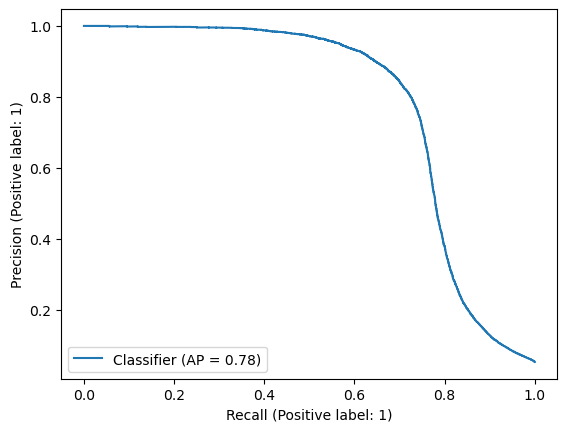

In [85]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true,y_pred)

ModuleNotFoundError: No module named 'openai'